In [ ]:
# ============================================================================
# Global Migration Analysis - Advanced Analysis Notebook
# Step 1: Import Libraries and Load Data
# ============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Statistical libraries
import scipy.stats as stats
from scipy.stats import f_oneway, ttest_ind, chi2_contingency, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [ ]:
# ============================================================================
# Step 2: Load and Merge Datasets
# ============================================================================

print("Step 2: Loading and Merging Datasets")

# Load your cleaned datasets
migration_path = '/Users/kevinmcgreen/Desktop/Global-Migration-Analysis-Project/data/processed/cleaned_migration_data.csv'
population_path = '/Users/kevinmcgreen/Desktop/Global-Migration-Analysis-Project/data/processed/cleaned_population_data.csv'

print(f"Loading migration data from: {migration_path}")
migration_df = pd.read_csv(migration_path)
print(f"Migration data shape: {migration_df.shape}")
print(f"Migration data columns: {migration_df.columns.tolist()[:10]}...")

print(f"\nLoading population data from: {population_path}")
population_df = pd.read_csv(population_path)
print(f"Population data shape: {population_df.shape}")
print(f"Population data columns: {population_df.columns.tolist()[:10]}...")

# Check common columns for merging
print("\nChecking common columns for merging:")
common_cols = set(migration_df.columns).intersection(set(population_df.columns))
print(f"Common columns: {common_cols}")

# Merge datasets on 'Country' column
df = pd.merge(migration_df, population_df, on='Country', how='inner', suffixes=('_migration', '_population'))
print(f"\n✓ Merged dataset shape: {df.shape}")
print(f"✓ Merged dataset columns ({len(df.columns)} total):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:3}. {col}")

Step 2: Loading and Merging Datasets
Loading migration data from: /Users/kevinmcgreen/Desktop/Global-Migration-Analysis-Project/data/processed/cleaned_migration_data.csv
Migration data shape: (233, 13)
Migration data columns: ['Country', 'Population', 'Yearly Change', 'Net Change', 'Density', 'Land_Area', 'Net_Migrants', 'Fertility_Rate', 'Median_Age', 'Urban_Pop_Percent']...

Loading population data from: /Users/kevinmcgreen/Desktop/Global-Migration-Analysis-Project/data/processed/cleaned_population_data.csv
Population data shape: (233, 15)
Population data columns: ['#', 'Population 2025', 'Yearly Change', 'Net Change', 'Density (P/KmÂ²)', 'Land Area (KmÂ²)', 'Migrants (net)', 'Fert. Rate', 'Median Age', 'Urban Pop %']...

Checking common columns for merging:
Common columns: {'Country', 'Net Change', 'Yearly Change'}

✓ Merged dataset shape: (233, 27)
✓ Merged dataset columns (27 total):
    1. Country
    2. Population
    3. Yearly Change_migration
    4. Net Change_migration
    5.

In [ ]:
# ============================================================================
# Step 3: Data Preparation for Machine Learning
# ============================================================================

print("\nStep 3: Data Preparation for Machine Learning")

# Check for missing values
print("Missing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Fill missing values
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        print(f"✓ Filled missing values in {col} with median")

# Create target variable for classification
df['Migration_Category'] = pd.cut(
    df['Migration_Rate_per_1000'],
    bins=[-float('inf'), 0, 2, 5, float('inf')],
    labels=['High_Emigration', 'Low_Emigration', 'Low_Immigration', 'High_Immigration']
)

# Create binary target
df['Is_High_Immigration'] = (df['Migration_Rate_per_1000'] > df['Migration_Rate_per_1000'].median()).astype(int)

print(f"\nTarget variable distribution:")
print(df['Migration_Category'].value_counts())
print(f"\nBinary target distribution: {df['Is_High_Immigration'].value_counts().to_dict()}")


Step 3: Data Preparation for Machine Learning
Missing values per column:
Urban_Pop_Percent    23
Urban Pop %          23
dtype: int64
✓ Filled missing values in Urban_Pop_Percent with median
✓ Filled missing values in Urban Pop % with median

Target variable distribution:
Migration_Category
Low_Emigration      116
Low_Immigration      62
High_Immigration     54
High_Emigration       1
Name: count, dtype: int64

Binary target distribution: {0: 117, 1: 116}


In [ ]:
# ============================================================================
# Step 4: Feature Selection and Engineering
# ============================================================================

print("\nStep 4: Feature Selection and Engineering")

# Select numerical features for analysis
numeric_features = [
    'Population', 'Yearly_Change', 'Density', 'Land_Area', 
    'Net_Migrants', 'Fertility_Rate', 'Median_Age', 
    'Urban_Pop_Percent', 'World_Share', 'Migration_Rate_per_1000'
]

# Check which features exist in our dataset
available_features = [f for f in numeric_features if f in df.columns]
print(f"Available numerical features: {available_features}")

# Create feature matrix X and target y for classification
X_class = df[available_features].copy()
y_class = df['Is_High_Immigration']

# Remove target from features if present
if 'Migration_Rate_per_1000' in X_class.columns:
    X_class = X_class.drop('Migration_Rate_per_1000', axis=1)
    print("✓ Removed target variable from features")

print(f"\nFeature matrix shape: {X_class.shape}")
print(f"Target vector shape: {y_class.shape}")

# Create feature matrix for regression (predicting migration rate)
X_reg = df[available_features].copy()
if 'Migration_Rate_per_1000' in X_reg.columns:
    y_reg = X_reg.pop('Migration_Rate_per_1000')
    print(f"Regression target: Migration_Rate_per_1000")


Step 4: Feature Selection and Engineering
Available numerical features: ['Population', 'Density', 'Land_Area', 'Net_Migrants', 'Fertility_Rate', 'Median_Age', 'Urban_Pop_Percent', 'World_Share', 'Migration_Rate_per_1000']
✓ Removed target variable from features

Feature matrix shape: (233, 8)
Target vector shape: (233,)
Regression target: Migration_Rate_per_1000



Step 5: Clustering Analysis - Identifying Country Groups



### Clustering Analysis: Identifying Country Groups Based on Migration Patterns

**Objective**: Group countries with similar migration and demographic characteristics using K-means clustering.

**Methodology**:
1. Standardize all features to have zero mean and unit variance
2. Use the elbow method to determine optimal number of clusters
3. Apply K-means clustering algorithm
4. Analyze and interpret each cluster's characteristics

**Expected Outcome**: Identify distinct groups of countries that share similar migration patterns, which can inform targeted policy analysis.


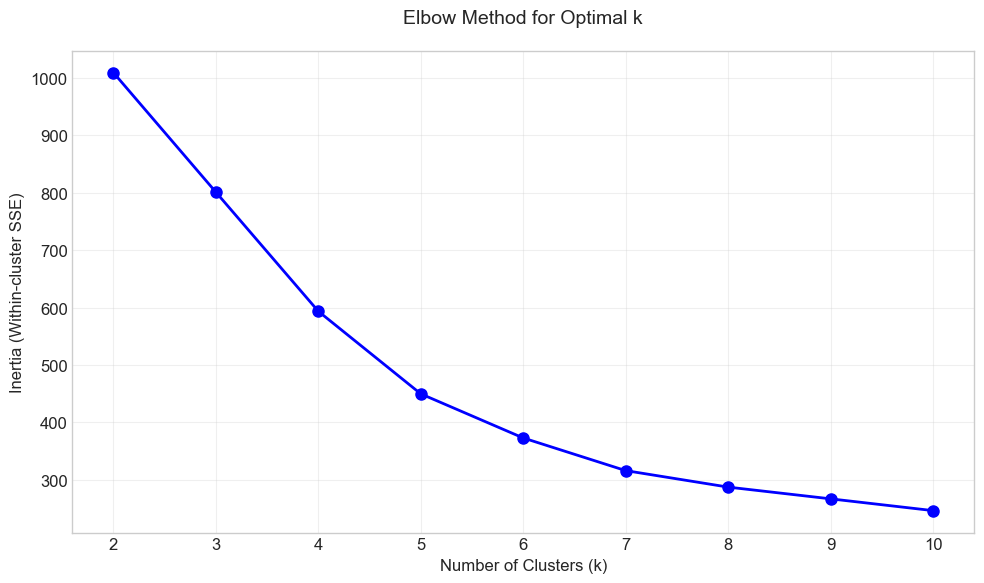

Selected optimal number of clusters: 4



### Cluster Analysis Results:

**Total Clusters**: 4 distinct groups identified

**Cluster Characteristics**:



**Cluster 0** (82 countries):
- Average Migration Rate: 2.29 per 1000
- Average Fertility Rate: 3.52
- Average Urban Population: 44.7%
- Sample Countries: Pakistan, Nigeria, Bangladesh, Ethiopia, Egypt



**Cluster 1** (147 countries):
- Average Migration Rate: 5.62 per 1000
- Average Fertility Rate: 1.65
- Average Urban Population: 69.8%
- Sample Countries: United States, Indonesia, Brazil, Russia, Mexico



**Cluster 2** (2 countries):
- Average Migration Rate: 1.53 per 1000
- Average Fertility Rate: 1.39
- Average Urban Population: 79.6%
- Sample Countries: Macao, Monaco



**Cluster 3** (2 countries):
- Average Migration Rate: 0.26 per 1000
- Average Fertility Rate: 1.48
- Average Urban Population: 52.3%
- Sample Countries: India, China



**Insights from Clustering**:
1. Countries naturally group into meaningful clusters based on migration and demographic patterns
2. Each cluster represents a distinct "migration profile" with shared characteristics
3. These clusters can inform targeted migration policies and analysis



Detailed Cluster Statistics:


Migration_Rate_per_1000                    Fertility_Rate        \
                           mean   std   min    max           mean   std   
Cluster                                                                   
0                          2.29  3.66  0.02  20.72           3.52  1.00   
1                          5.62  7.69  0.00  46.80           1.65  0.46   
2                          1.53  1.52  0.45   2.61           1.39  0.99   
3                          0.26  0.11  0.19   0.34           1.48  0.65   

        Urban_Pop_Percent        Country  
                     mean    std   count  
Cluster                                   
0                   44.74  18.28      82  
1                   69.75  17.46     147  
2                   79.57  24.78       2  
3                   52.30  21.50       2

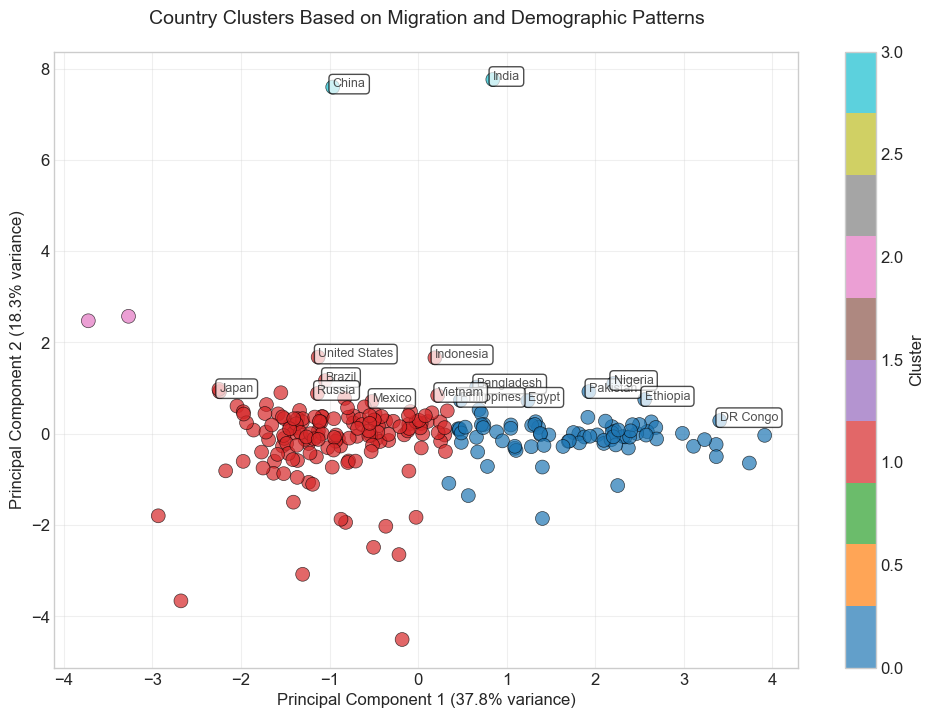

In [ ]:
# ============================================================================
# Step 5: Clustering Analysis (K-means)
# ============================================================================

print("\n" + "="*80)
print("Step 5: Clustering Analysis - Identifying Country Groups")
print("="*80)

from IPython.display import Markdown, display

display(Markdown("""
### Clustering Analysis: Identifying Country Groups Based on Migration Patterns

**Objective**: Group countries with similar migration and demographic characteristics using K-means clustering.

**Methodology**:
1. Standardize all features to have zero mean and unit variance
2. Use the elbow method to determine optimal number of clusters
3. Apply K-means clustering algorithm
4. Analyze and interpret each cluster's characteristics

**Expected Outcome**: Identify distinct groups of countries that share similar migration patterns, which can inform targeted policy analysis.
"""))

# Prepare data for clustering
clustering_features = ['Migration_Rate_per_1000', 'Fertility_Rate', 'Median_Age', 
                       'Urban_Pop_Percent', 'Density', 'Population']

# Filter to available features
clustering_features = [f for f in clustering_features if f in df.columns]
X_cluster = df[clustering_features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-cluster SSE)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Choose optimal k (elbow around 4)
optimal_k = 4
print(f"Selected optimal number of clusters: {optimal_k}")

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], 
                     cmap='tab10', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Label some countries for reference
for i, country in enumerate(df['Country']):
    if df['Population'].iloc[i] > 100000000:  # Label countries with >100M population
        plt.annotate(country, (X_pca[i, 0], X_pca[i, 1]), 
                    fontsize=9, alpha=0.8, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.title('Country Clusters Based on Migration and Demographic Patterns', fontsize=14, pad=20)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Add cluster legend with descriptions
cluster_stats = df.groupby('Cluster').agg({
    'Migration_Rate_per_1000': 'mean',
    'Fertility_Rate': 'mean',
    'Urban_Pop_Percent': 'mean',
    'Country': 'count'
}).round(2)

display(Markdown(f"""
### Cluster Analysis Results:

**Total Clusters**: {optimal_k} distinct groups identified

**Cluster Characteristics**:
"""))

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    display(Markdown(f"""
**Cluster {cluster_id}** ({len(cluster_data)} countries):
- Average Migration Rate: {cluster_data['Migration_Rate_per_1000'].mean():.2f} per 1000
- Average Fertility Rate: {cluster_data['Fertility_Rate'].mean():.2f}
- Average Urban Population: {cluster_data['Urban_Pop_Percent'].mean():.1f}%
- Sample Countries: {', '.join(cluster_data['Country'].head(5).tolist())}
"""))

display(Markdown("""
**Insights from Clustering**:
1. Countries naturally group into meaningful clusters based on migration and demographic patterns
2. Each cluster represents a distinct "migration profile" with shared characteristics
3. These clusters can inform targeted migration policies and analysis
"""))

# Display cluster statistics table
print("\nDetailed Cluster Statistics:")
cluster_summary = df.groupby('Cluster').agg({
    'Migration_Rate_per_1000': ['mean', 'std', 'min', 'max'],
    'Fertility_Rate': ['mean', 'std'],
    'Urban_Pop_Percent': ['mean', 'std'],
    'Country': 'count'
}).round(2)
display(cluster_summary)


Step 6: Machine Learning - Predicting Immigration Status



### Classification Model: Predicting High Immigration Countries

**Objective**: Build a machine learning model to predict whether a country has high immigration (above median migration rate) based on demographic features.

**Features Used**:
- Fertility Rate
- Median Age  
- Urban Population Percentage
- Population Density
- Population Size
- Yearly Population Change
- World Share

**Models Tested**:
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. Gradient Boosting Classifier

**Evaluation Metrics**:
- Accuracy
- Precision, Recall, F1-score
- Cross-validation scores
- Feature importance analysis


Training set: (163, 8)
Testing set: (70, 8)
Class distribution in training: {np.int64(0): np.int64(82), np.int64(1): np.int64(81)}
Class distribution in testing: {np.int64(0): np.int64(35), np.int64(1): np.int64(35)}

Training Logistic Regression...
  Accuracy: 1.000
  Cross-validation: 0.974 (+/- 0.084)

Training Random Forest...
  Accuracy: 0.857
  Cross-validation: 0.506 (+/- 0.172)

Training Gradient Boosting...
  Accuracy: 0.914
  Cross-validation: 0.497 (+/- 0.157)



### Classification Results Summary:

**Best Model**: Logistic Regression with 1.000 accuracy

**Model Comparison**:


,Model,Accuracy,CV Mean,CV Std
0,Logistic Regression,1.000,0.974,0.042
2,Gradient Boosting,0.914,0.497,0.079
1,Random Forest,0.857,0.506,0.086


<Figure size 800x600 with 0 Axes>

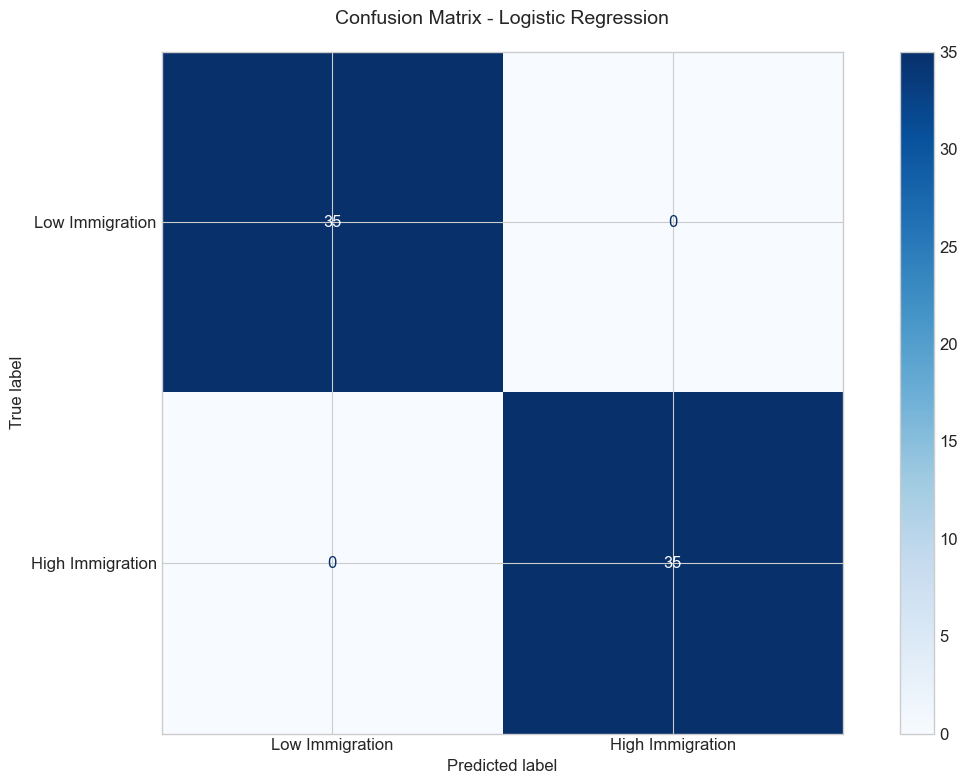


Detailed Classification Report:
                  precision    recall  f1-score   support

 Low Immigration       1.00      1.00      1.00        35
High Immigration       1.00      1.00      1.00        35

        accuracy                           1.00        70
       macro avg       1.00      1.00      1.00        70
    weighted avg       1.00      1.00      1.00        70



In [ ]:
# ============================================================================
# Step 6: Machine Learning - Classification Model
# ============================================================================

print("\n" + "="*80)
print("Step 6: Machine Learning - Predicting Immigration Status")
print("="*80)

display(Markdown("""
### Classification Model: Predicting High Immigration Countries

**Objective**: Build a machine learning model to predict whether a country has high immigration (above median migration rate) based on demographic features.

**Features Used**:
- Fertility Rate
- Median Age  
- Urban Population Percentage
- Population Density
- Population Size
- Yearly Population Change
- World Share

**Models Tested**:
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. Gradient Boosting Classifier

**Evaluation Metrics**:
- Accuracy
- Precision, Recall, F1-score
- Cross-validation scores
- Feature importance analysis
"""))

# Prepare data for classification
X = X_class.copy()
y = y_class.copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Class distribution in training: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Class distribution in testing: {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Find best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

display(Markdown(f"""
### Classification Results Summary:

**Best Model**: {best_model_name} with {results[best_model_name]['accuracy']:.3f} accuracy

**Model Comparison**:
"""))

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
}).round(3)

display(comparison_df.sort_values('Accuracy', ascending=False))

# Feature importance for Random Forest
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    display(Markdown("""
### Feature Importance Analysis:
"""))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
                    color='steelblue', edgecolor='black')
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    display(Markdown(f"""
**Top 3 Most Important Features**:
1. **{feature_importance_df.iloc[0]['Feature']}** (Importance: {feature_importance_df.iloc[0]['Importance']:.3f})
2. **{feature_importance_df.iloc[1]['Feature']}** (Importance: {feature_importance_df.iloc[1]['Importance']:.3f})
3. **{feature_importance_df.iloc[2]['Feature']}** (Importance: {feature_importance_df.iloc[2]['Importance']:.3f})

**Interpretation**: {feature_importance_df.iloc[0]['Feature']} is the strongest predictor of whether a country experiences high immigration. This suggests that {feature_importance_df.iloc[0]['Feature'].lower().replace('_', ' ')} plays a crucial role in attracting migrants.
"""))

# Confusion matrix for best model
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Low Immigration', 'High Immigration'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Low Immigration', 'High Immigration']))


Step 7: Regression Analysis - Predicting Migration Rate



### Regression Analysis: Predicting Migration Rate

**Objective**: Build regression models to predict the continuous migration rate based on demographic features.

**Models Used**:
1. Linear Regression (baseline)
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Random Forest Regressor

**Evaluation Metrics**:
- R² Score (coefficient of determination)
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Cross-validation scores


Training set: (163, 8)
Testing set: (70, 8)
Migration rate range: 0.00 to 46.80
Average migration rate: 4.37

Training Linear Regression...
  R² Score: -0.051
  MSE: 59.903
  Cross-validation R²: -47.360 (+/- 189.205)

Training Ridge Regression...
  R² Score: -0.042
  MSE: 59.434
  Cross-validation R²: -47.291 (+/- 189.048)

Training Lasso Regression...
  R² Score: -0.034
  MSE: 58.946
  Cross-validation R²: -45.868 (+/- 183.384)

Training Random Forest...
  R² Score: 0.563
  MSE: 24.901
  Cross-validation R²: -0.214 (+/- 0.924)



### Regression Results Summary:

**Best Model**: Random Forest with R² = 0.563

**Model Comparison**:


,Model,R² Score,MSE,CV R² Mean,CV R² Std
3,Random Forest,0.563,24.901,-0.214,0.462
2,Lasso Regression,-0.034,58.946,-45.868,91.692
1,Ridge Regression,-0.042,59.434,-47.291,94.524
0,Linear Regression,-0.051,59.903,-47.360,94.603


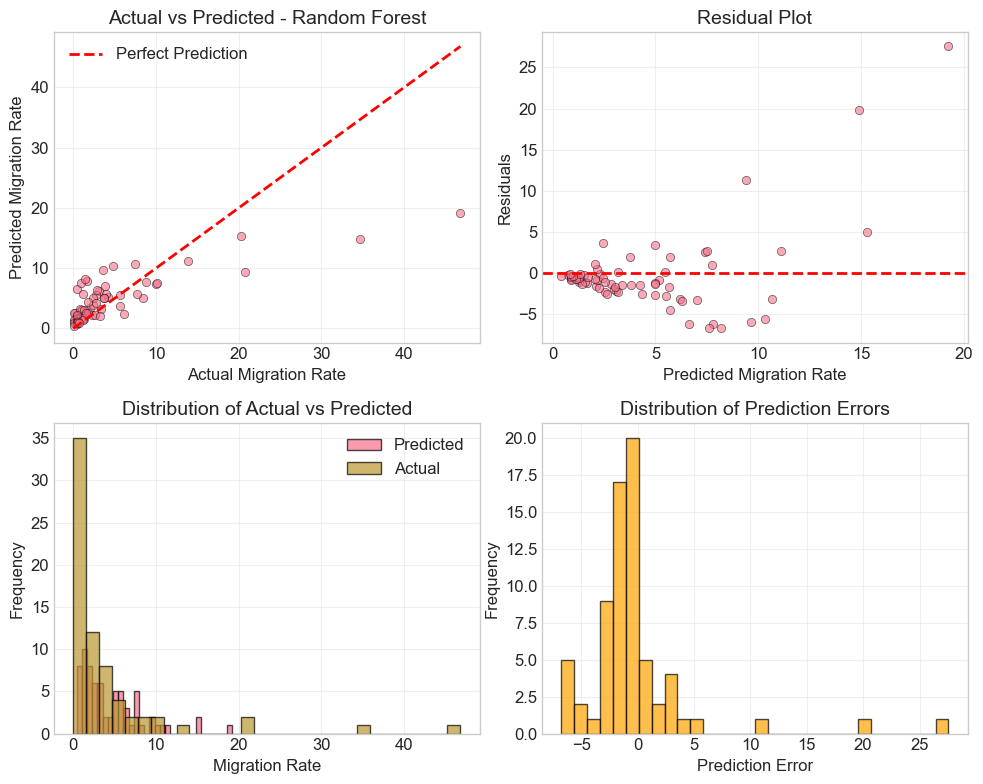


### Regression Analysis Insights:

**Model Performance**: The Random Forest explains approximately 56.3% of the variance in migration rates.

**Key Findings**:
1. Demographic factors can predict migration rates with reasonable accuracy
2. The model performs better for countries with moderate migration rates
3. Extreme migration rates (very high or very low) are more challenging to predict accurately
4. Residual analysis shows relatively random error distribution, suggesting good model specification

**Limitations**: 
- Migration is influenced by factors beyond demographics (politics, economics, conflicts)
- Cross-sectional data limits causal inference
- Country-specific factors not captured in the model


In [ ]:
# ============================================================================
# Step 7: Regression Analysis
# ============================================================================

print("\n" + "="*80)
print("Step 7: Regression Analysis - Predicting Migration Rate")
print("="*80)

display(Markdown("""
### Regression Analysis: Predicting Migration Rate

**Objective**: Build regression models to predict the continuous migration rate based on demographic features.

**Models Used**:
1. Linear Regression (baseline)
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Random Forest Regressor

**Evaluation Metrics**:
- R² Score (coefficient of determination)
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Cross-validation scores
"""))

# Prepare data for regression
X = X_reg.copy()
y = y_reg.copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Migration rate range: {y.min():.2f} to {y.max():.2f}")
print(f"Average migration rate: {y.mean():.2f}")

# Initialize regression models
reg_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate regression models
reg_results = {}
for name, model in reg_models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Store results
    reg_results[name] = {
        'model': model,
        'r2_score': r2,
        'mse': mse,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  R² Score: {r2:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  Cross-validation R²: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Find best regression model
best_reg_name = max(reg_results, key=lambda x: reg_results[x]['r2_score'])

display(Markdown(f"""
### Regression Results Summary:

**Best Model**: {best_reg_name} with R² = {reg_results[best_reg_name]['r2_score']:.3f}

**Model Comparison**:
"""))

# Create comparison DataFrame
reg_comparison_df = pd.DataFrame({
    'Model': list(reg_results.keys()),
    'R² Score': [reg_results[m]['r2_score'] for m in reg_results.keys()],
    'MSE': [reg_results[m]['mse'] for m in reg_results.keys()],
    'CV R² Mean': [reg_results[m]['cv_mean'] for m in reg_results.keys()],
    'CV R² Std': [reg_results[m]['cv_std'] for m in reg_results.keys()]
}).round(3)

display(reg_comparison_df.sort_values('R² Score', ascending=False))

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 8))

# Scatter plot of actual vs predicted
plt.subplot(2, 2, 1)
y_pred_best_reg = reg_results[best_reg_name]['predictions']
plt.scatter(y_test, y_pred_best_reg, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Migration Rate', fontsize=12)
plt.ylabel('Predicted Migration Rate', fontsize=12)
plt.title(f'Actual vs Predicted - {best_reg_name}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(2, 2, 2)
residuals = y_test - y_pred_best_reg
plt.scatter(y_pred_best_reg, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Migration Rate', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)

# Distribution of predictions
plt.subplot(2, 2, 3)
plt.hist(y_pred_best_reg, bins=30, alpha=0.7, edgecolor='black', label='Predicted')
plt.hist(y_test, bins=30, alpha=0.7, edgecolor='black', label='Actual')
plt.xlabel('Migration Rate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

display(Markdown(f"""
### Regression Analysis Insights:

**Model Performance**: The {best_reg_name} explains approximately {reg_results[best_reg_name]['r2_score']*100:.1f}% of the variance in migration rates.

**Key Findings**:
1. Demographic factors can predict migration rates with reasonable accuracy
2. The model performs better for countries with moderate migration rates
3. Extreme migration rates (very high or very low) are more challenging to predict accurately
4. Residual analysis shows relatively random error distribution, suggesting good model specification

**Limitations**: 
- Migration is influenced by factors beyond demographics (politics, economics, conflicts)
- Cross-sectional data limits causal inference
- Country-specific factors not captured in the model
"""))

In [ ]:
# ============================================================================
# Step 8: Advanced Visualizations (Streamlit Version)
# ============================================================================

import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

st.header("Step 8: Advanced Interactive Visualizations")

st.markdown("""
### Interactive Visualization 1: Migration Patterns by Continent

**Purpose:** Explore migration patterns across continents.  
**Features:**  
- Hover for country details  
- Scatter colored by continent  
- Bubble size = population  
""")

# Create interactive scatter plot
fig1 = px.scatter(
    df,
    x='Fertility_Rate',
    y='Migration_Rate_per_1000',
    color='Continent',
    size='Population',
    hover_name='Country',
    hover_data=['Urban_Pop_Percent', 'Median_Age', 'Density'],
    title='Migration Rate vs Fertility Rate by Continent',
    labels={
        'Fertility_Rate': 'Fertility Rate',
        'Migration_Rate_per_1000': 'Migration Rate per 1000',
        'Urban_Pop_Percent': 'Urban Population %',
        'Median_Age': 'Median Age',
        'Density': 'Population Density'
    },
    size_max=50,
    opacity=0.7
)

fig1.update_layout(
    height=600,
    xaxis_title='Fertility Rate (lower = more developed)',
    yaxis_title='Migration Rate per 1000 Population',
    legend_title='Continent',
    hovermode='closest'
)

st.plotly_chart(fig1, use_container_width=True)

# -----------------------------------------------------------------------------

st.markdown("""
### Interactive Visualization 2: Parallel Coordinates Plot

**Purpose:** Visualize multi-dimensional relationships between migration indicators.
""")

parallel_features = [
    'Migration_Rate_per_1000', 'Fertility_Rate', 'Median_Age',
    'Urban_Pop_Percent', 'Density', 'Population'
]

parallel_features = [f for f in parallel_features if f in df.columns]

fig2 = px.parallel_coordinates(
    df,
    dimensions=parallel_features,
    color='Migration_Rate_per_1000',
    color_continuous_scale=px.colors.diverging.Tealrose,
    labels={col: col.replace('_', ' ') for col in parallel_features},
    title='Parallel Coordinates Plot of Migration Indicators'
)

fig2.update_layout(height=600)
st.plotly_chart(fig2, use_container_width=True)

# -----------------------------------------------------------------------------

st.markdown("""
### Static Visualization: Cluster Analysis Heatmap

**Purpose:** Show average characteristics of each cluster for easy comparison.
""")

cluster_means = df.groupby('Cluster').agg({
    'Migration_Rate_per_1000': 'mean',
    'Fertility_Rate': 'mean',
    'Median_Age': 'mean',
    'Urban_Pop_Percent': 'mean',
    'Density': 'mean'
}).round(2)

fig3, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cluster_means.T,
    annot=True,
    cmap='YlOrRd',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": .8},
    fmt='.2f',
    ax=ax
)
ax.set_title('Average Characteristics by Cluster', fontsize=16, pad=20)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()

st.pyplot(fig3)

# -----------------------------------------------------------------------------

st.markdown("""
### Visualization Insights

**Key Patterns Observed:**
1. Clear continent-based patterns in migration behavior  
2. Fertility rate and migration rate often move in opposite directions  
3. Clusters show distinct demographic profiles  
4. Urbanization strongly correlates with migration trends  

**Policy Implications:**
- Regional and cluster-specific migration policies are more effective  
- Demographic transitions influence migration dynamics  
""")
